In [211]:
import math
import matplotlib
from matplotlib.ticker import FixedLocator, LogFormatter
from core.util import matplotlib_setting, read_row, std_tri, std_rect, read_column, lin_regression, format_with_error, intersect_parabula
from core.fit import fit_poly, fit_exp, fit_expquad_dif_evol
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

matplotlib_setting()
file_path = "./../data/mag.xlsx"
df = pd.read_excel(file_path, 'Magnetfelder', header=None)

length1A = read_row(df, 0, start_col=2)
length15A = read_row(df, 7, start_col=2)
lengthTV = read_row(df, 14, start_col=2)

noiseB1A = read_row(df, 1, start_col=2)
noiseB15A = read_row(df, 8, start_col=2)
noiseBTV = read_row(df, 15, start_col=2)

def b_field_err(arr):
    return np.sqrt((arr*0.003)**2 + (arr*0.002)**2 + std_rect(0.1))

length1A_err = np.sqrt((length1A*0.0025)**2 + 0.1**2)
length15A_err = np.sqrt((length15A*0.0025)**2 + 0.1**2)
lengthTV_err = np.sqrt((lengthTV*0.0025)**2 + 0.1**2)

noiseB1A_err = b_field_err(noiseB1A)
noiseB15A_err =  b_field_err(noiseB15A)
noiseBTV_err =  b_field_err(noiseBTV)

emptyB1A = read_row(df, 2, remove_nan=False, start_col=2)
emptyB15A = read_row(df, 9, remove_nan=True, start_col=2)
emptyBTV = read_row(df, 16, remove_nan=False, start_col=2)

emptyB1A_err = b_field_err(emptyB1A)
emptyB15A_err = b_field_err(emptyB15A)
emptyBTV_err = b_field_err(emptyBTV)

filledB1A = read_row(df, 3, remove_nan=False, start_col=2)
filledB1A_err = b_field_err(filledB1A)

print(length15A)
print(emptyB15A)

[ 0.   1.   2.   3.   3.5  4.   5.   6.   7.   8.   9.  10.  11.  12.
 13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  25.  27.  30.
 35.  40.  45.  50. ]
[13.5 20.3 24.2 25.8 25.8 25.8 24.3 20.8 14.5  8.8  5.5  3.5  2.3  1.6
  1.1  0.8  0.6  0.5  0.4  0.3  0.3  0.2  0.2  0.1  0.1  0.1  0.   0.
  0.   0.  -0.1 -0.1]


/var/folders/y4/8b_9bd3j179gbmftvg2wpkg00000gn/T/ipykernel_15356/876159541.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 25})


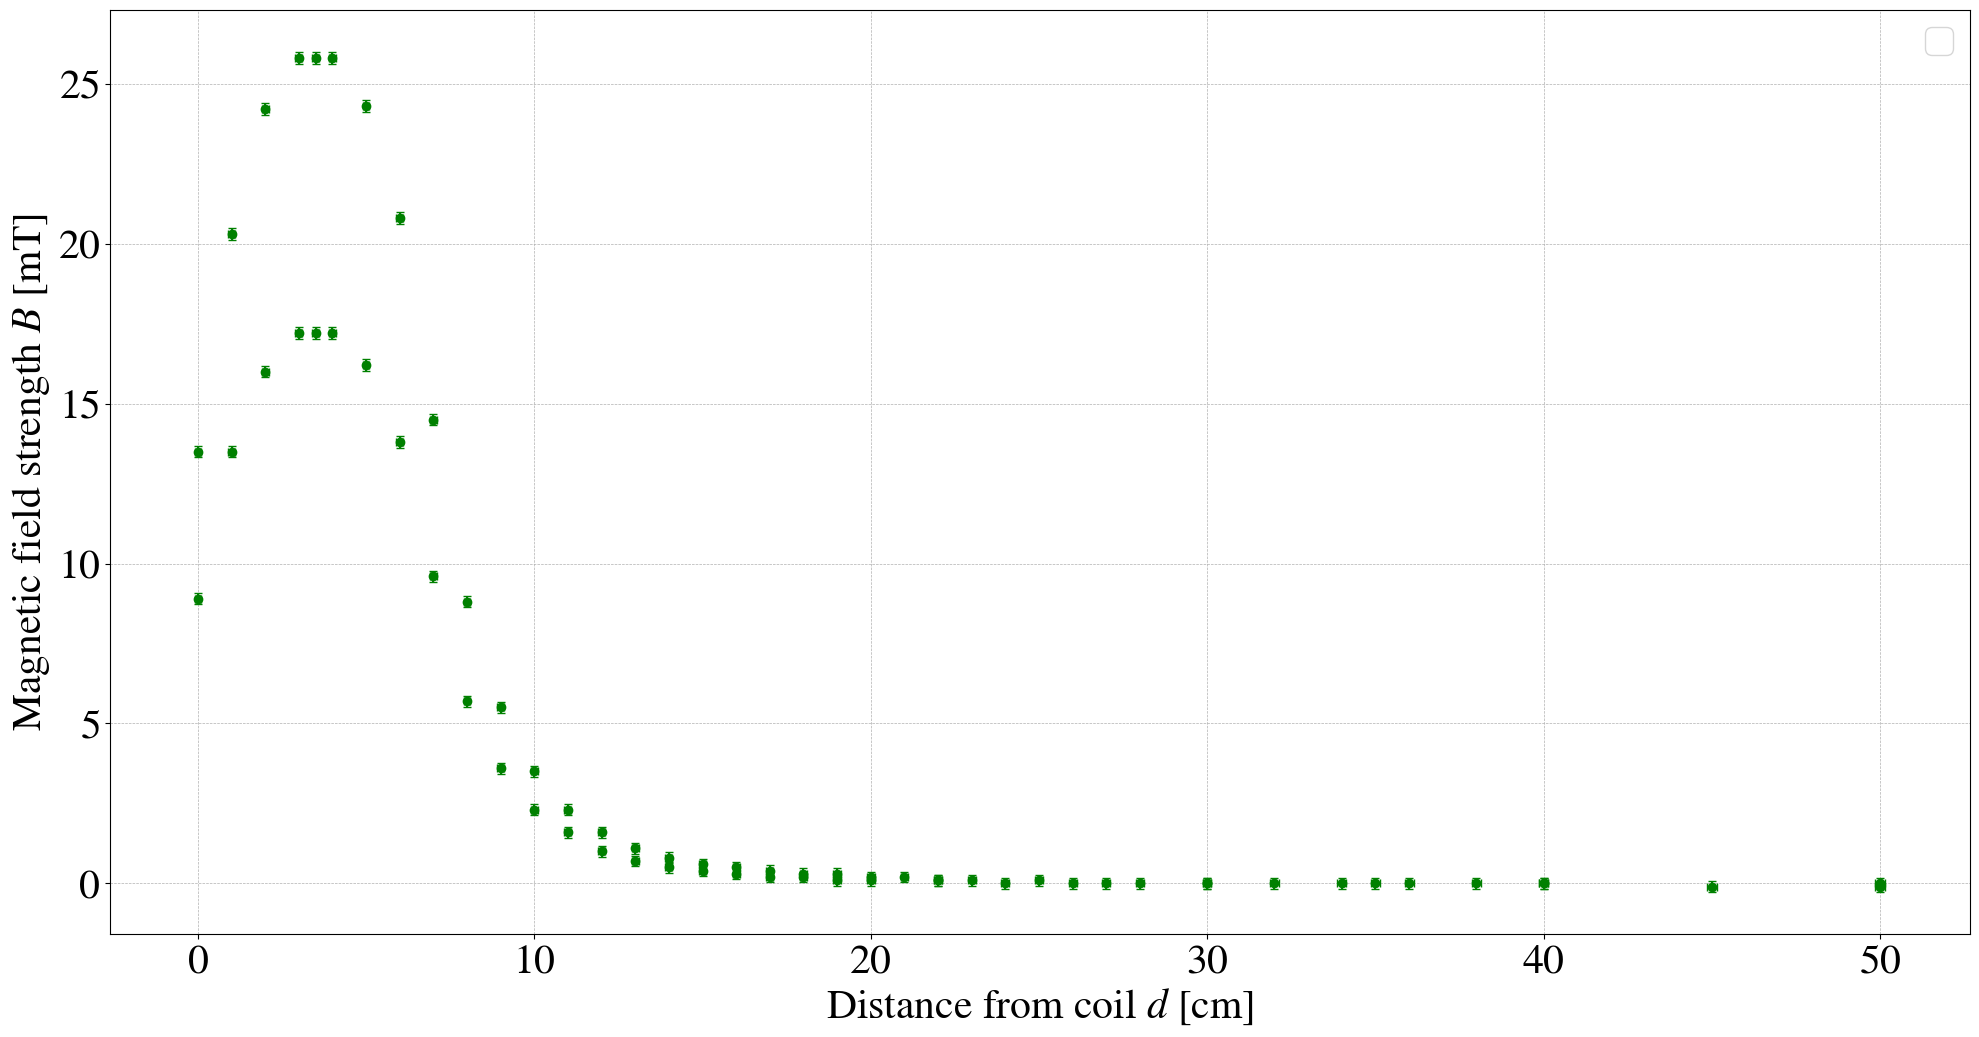

In [212]:
plt.errorbar(
    length1A, emptyB1A,
    xerr=length1A_err, yerr=emptyB1A_err,
    label=r'$I_\mathrm{max}=1.0\ \mathrm{A}$',
    fmt='go', capsize=3
)

plt.errorbar(
    length15A, emptyB15A,
    xerr=length15A_err, yerr=emptyB15A_err,
    label=r'$I_\mathrm{max}=1.5\ \mathrm{A}$',
    fmt='ro', capsize=3
)

'''
plt.errorbar(
    length1A[9:], filledB1A[9:],
    xerr=length1A_err[9:], yerr=filledB1A_err[9:],
    fmt='ro', capsize=3,
)'''

plt.xlabel(r"Distance from coil $d\ \mathrm{[cm]}$")
plt.ylabel(r"Magnetic field strength $B\ \mathrm{[mT]}$")

#x_ticks = np.arange(10, 121, 10)  # 10, 20, 30 ... 120
#plt.xlim(10, 120)
#plt.xticks(x_ticks, labels=x_ticks)  # force tick labels
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(prop={'size': 25})
plt.savefig('figures/mag.pdf')

3.9695598394098455 0.11289418890540691


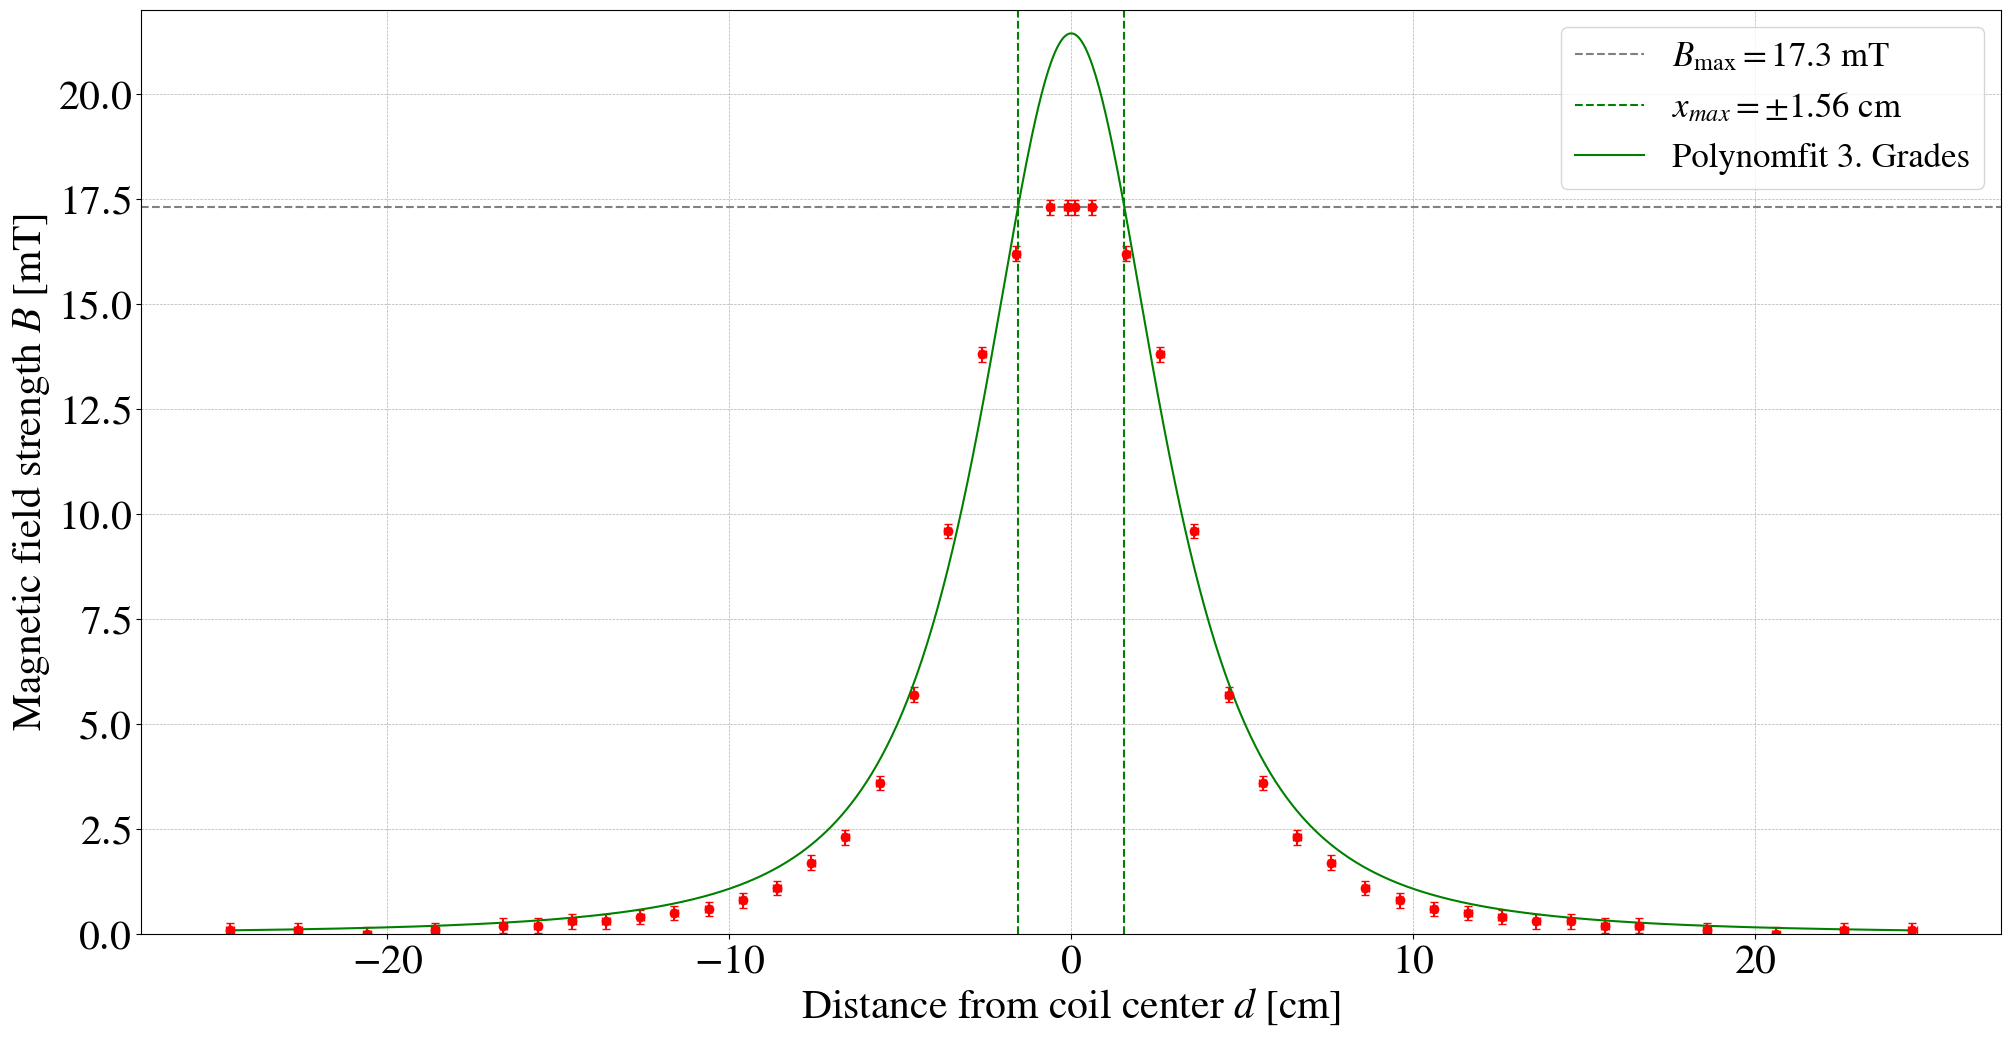

In [213]:
from scipy.optimize import differential_evolution
from core.fit import FitData

middle_point = 3.395
def fit_circular_coil(x_values, y_values, bounds):
    my_0 = 1.256637
    n = 1200

    def biot_savart(x, reff, ieff):
        return n * my_0 * reff**2 * ieff / (2*(x**2 + reff**2)**(3/2))
    def residual(params):
        reff, ieff = params
        model = biot_savart(x_values, reff, ieff)
        return np.sum((y_values - model) ** 2)

    result = differential_evolution(residual, bounds, seed=2, polish=True)
    best_params = result.x

    reff, ieff = best_params
    xmax = np.sqrt(((my_0*reff**2*n*ieff)/(2*17.3))**(2/3) - reff**2)
    x_fit = np.linspace(min(x_values), max(x_values), 1000)
    y_fit = biot_savart(x_fit, reff, ieff)
    print(reff, ieff)
    return FitData(x_fit, y_fit, best_params, xmax)

mirrorlen = np.concatenate((-(length1A[4:26]-middle_point), (length1A[4:26]-middle_point)))
mirrorlenFit = np.concatenate((-(length1A[6:26]-middle_point), (length1A[6:26]-middle_point)))
mirrorB1A = np.concatenate((emptyB1A[4:26]-noiseB1A[4:26], emptyB1A[4:26]-noiseB1A[4:26]))
mirrorB1AFit = np.concatenate((emptyB1A[6:26]-noiseB1A[6:26], emptyB1A[6:26]-noiseB1A[6:26]))

plt.errorbar(
    mirrorlen, mirrorB1A,
    xerr=np.concat((length1A_err[4:26], length1A_err[4:26])), yerr=np.concat((emptyB1A_err[4:26], emptyB1A_err[4:26])),
    fmt='ro', capsize=3,
)

fit = fit_circular_coil(mirrorlenFit, mirrorB1AFit, [(0, 6), (0, 100)])


plt.axhline(17.3, color='gray', linestyle='--', label=r'$B_\mathrm{max}=17.3\ \mathrm{mT}$')
plt.axvline(-fit.cov, color='green', linestyle='--', label=r'$x_{max}=\pm$'+f'{fit.cov:.2f} cm')
plt.axvline(fit.cov, color='green', linestyle='--')


plt.xlabel(r"Distance from coil center $d\ \mathrm{[cm]}$")
plt.ylabel(r"Magnetic field strength $B\ \mathrm{[mT]}$")

#x_ticks = np.arange(10, 121, 10)  # 10, 20, 30 ... 120
plt.ylim(0, 22)
#plt.xticks(x_ticks, labels=x_ticks)  # force tick labels
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.plot(fit.x_fit, fit.y_fit, color="green", label="Polynomfit 3. Grades")
plt.legend(prop={'size': 25})
plt.savefig('figures/leerespigel.pdf')
